# Modelos
## Nombre: Ramón Llorente

## Introducción
### Luego de haber buceado un poco en los datos en el proceso exploratorio, nos abocamos a intentar entrenar un modelo que pueda predecir la variable *sold_quantity* . 
### Para comenzar, establecemos los criterios principales para este itinerario:
* Entrenaremos un modelo linear como _baseline_ desde donde ir creciendo
* Entrenaremos un modelo no lineal, _"shallow"_.
* Evaluaremos las métricas MSE y R2, y sacaremos nuestras conclusiones

## Hipótesis

#### Si bien se puede ver en el gráfico de correlaciones mas abajo, que no hay relación lineal entre la variable a predecir y las predictoras, creemos que con una poda de variables con colinearidad o con una correspondiente regularización, mas transformación de variables numéricas, podremos ver algun resultado.
#### Por otro la variable objetivo, al tratarse de cuentas, como hemos visto en el EDA, con características de la familia de Poisson, podria modelarse con dicha distribución dentro del _framework_ de regresione lineal generalizada (GLM).

#### Por otro lado, en cuanto al model no-lineal, creemos que un ensamble de árboles de desición podria performar bien en el contexto de un dataset con muchas variables, en datos tabulares, con una considerable buena performance desde el punto de vista métrico.

#### En cuanto a las variables, y por lo que hemos visto en el proceso exploratorio, creemos que seran de gran importancia las variables predictoras _health_ , _price_ , _diff_stop_start_time_ . La primera porque parece condensar y resumir informacion presente en muchas otras variables, sobre puntaje y performance del vendedor, la segunda porque creemos que el precio deberia estar relacionado con la cantidad de ítems a vender: si es un ítem caro no deberia venderse facilmente. Y por ultimo la diferencia de dias entre fecha de comienzo y fecha de finalización del ítem, porque creemos que hay un factor temporal en el tiempo que ha pasado desde su publicación.

## Metodología y Herramientas
### Para este trabajo adoptaremos el algoritmo de regresión lineal generalizada de la librería Stats Models, para el modelo base, y luego para el siguiente utilizaremos una variante de Gradient Boosting Trees, que utiliza el gradiente natural para ajustar la secuencia de árboles, ya que es mas efectivo, porque es paramétrico: esto quiere decir que ajusta la probabilidad condicional P(Y | Datos), asignando una familia de distribuciones. 

### Para estimar el error del test, haremos un cros validation de 8 folios, y tambien dejaremos un conjunto "Held Out" para observar la performance sobre un conjunto de datos "guardado". 


In [1]:

import random

import statsmodels.api as sm

import pandas as pd
import numpy as np

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In /home/ramon/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ramon/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ramon/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/ramon/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ramon/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [2]:
random.seed(3890)

In [3]:
df = pd.read_pickle('master4models_prepro.df')
df.head()

,seller_ratings_negative,seller_ratings_neutral,seller_ratings_positive,seller_transactions_total,seller_sales_completed,seller_claims_value,seller_claims_rate,seller_cancellations_rate,seller_cancellations_value,seller_delayed_handling_value,...,shipping_mode_me2,shipping_mode_not_specified,start_time_month,start_time_year,stop_time_month,stop_time_year,seller_registration_date_month,seller_registration_date_year,diff_stop_start_time,lof_negative_label
0,0.0,0.0,0.0,12283.0,1965.0,37.0,0.02,0.0,1.0,36.0,...,0.0,1.0,8.0,2020.0,7.0,2040.0,10.0,2016.0,7299.52,-1.162979
1,0.0,0.0,0.0,12283.0,1965.0,37.0,0.02,0.0,1.0,36.0,...,1.0,0.0,10.0,2020.0,10.0,2040.0,10.0,2016.0,7299.41,-1.040410
2,0.0,0.0,0.0,367677.0,60652.0,422.0,0.01,0.0,59.0,0.0,...,1.0,0.0,9.0,2020.0,9.0,2040.0,3.0,2019.0,7299.76,-5.715320
3,0.0,0.0,0.0,271928.0,88340.0,606.0,0.01,0.0,0.0,0.0,...,1.0,0.0,10.0,2020.0,11.0,2040.0,7.0,2020.0,7335.96,-1.012877
4,0.0,0.0,0.0,271928.0,88340.0,606.0,0.01,0.0,0.0,0.0,...,1.0,0.0,10.0,2020.0,11.0,2040.0,7.0,2020.0,7336.36,-1.374617


In [4]:
df.shape

(27843, 49)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27843 entries, 0 to 28058
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   seller_ratings_negative         27761 non-null  float64
 1   seller_ratings_neutral          27761 non-null  float64
 2   seller_ratings_positive         27761 non-null  float64
 3   seller_transactions_total       27761 non-null  float64
 4   seller_sales_completed          27760 non-null  float64
 5   seller_claims_value             27759 non-null  float64
 6   seller_claims_rate              27760 non-null  float64
 7   seller_cancellations_rate       27759 non-null  float64
 8   seller_cancellations_value      27759 non-null  float64
 9   seller_delayed_handling_value   27759 non-null  float64
 10  seller_delayed_handling_rate    27760 non-null  float64
 11  condition                       27843 non-null  float64
 12  installments_quantity           

### Separamos los datos que usaremos en los models

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df.fillna(0).drop('sold_quantity', axis=1).values, 
    df.sold_quantity.values, 
    test_size=0.33, 
    random_state=24)

## Modelo 1: Regresión GML Poisson

#### Veamos de modo interpretativo los coeficientes y error std del modelo lineal

In [77]:
po_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(po_results.summary()), print(df.columns.tolist())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                18654
Model:                            GLM   Df Residuals:                    18609
Model Family:                 Poisson   Df Model:                           44
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.0482e+17
Date:                Fri, 12 Mar 2021   Deviance:                   4.0964e+17
Time:                        16:18:05   Pearson chi2:                 2.05e+17
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1                  0          0        nan        n

(None, None)

### Se puede ver a simple vista que el modelo no se entiende con este dataset tal como esta, por los coeficientes tan bajos , lo mismo que los errores estandar.

### Intentaré quitar y transformar algunas

In [54]:
col_rl = ['health', 'price', 'sold_quantity', 
          'user_visits', 'domain_cluster' ,'seller_reputation_level_5',
          'diff_stop_start_time', 'power_seller_status_enc', 'buying_mode_now']
numeric_cl = ['health','price','user_visits', 'diff_stop_start_time']
df_rl = df[col_rl]
for cn in numeric_cl:
    df_rl[cn] = df_rl[cn] - df_rl[cn].mean() / df_rl[cn].std()

df_rl['health_price_inter'] = df_rl.price * df_rl.health    

X_train_rl, X_test_rl, y_train_rl, y_test_rl = train_test_split(
    df_rl.fillna(0).drop('sold_quantity', axis=1).values, 
    df_rl.sold_quantity.values, 
    test_size=0.33, 
    random_state=24)

/home/ramon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/ramon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [55]:
po_results_trun = sm.GLM(y_train_rl, X_train_rl, family=sm.families.Poisson()).fit()
print(po_results_trun.summary()), print(df_rl.drop('sold_quantity', axis=1).columns.tolist())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                18654
Model:                            GLM   Df Residuals:                    18645
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1415e+06
Date:                Fri, 12 Mar 2021   Deviance:                   2.2285e+06
Time:                        17:56:57   Pearson chi2:                 1.77e+07
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1487      0.001    174.900      0.0

(None, None)

### Ahora hemos podado las variables y vemos que se clarifican los coeficientes, y el error estándar ha mejorado , por lo tanto mejoro la estimación. 
### Algunas cosas a decir al respecto: La variable generada diff_stop_start_time , no parece tener importancia en la predicción del target según este modelo. Por otro lado, parece tener importancia el precio, y buying_mode, ambas con std err bajo. Luego seller_reputation_level_5 tambien parece ser relevante. 
### Con eso podriamos confirmar que los vendedores de buena reputación crecen positivamente casi dos unidades logarítmicas de la cantidad vendida.

In [46]:
metrics = {
    'mse': mean_squared_error,
    'r2': r2_score
}

In [111]:
test_results_d = {}

In [56]:
sm_metrics = pd.DataFrame()
sm_results_stored = {}


kf = KFold(n_splits=8)

for i, (train_index, test_index) in enumerate(kf.split(X_train_rl)):
    X_train_cv, X_val = X_train_rl[train_index], X_train_rl[test_index]
    y_train_cv, y_val = y_train_rl[train_index], y_train_rl[test_index]

    sm_results_stored[i] = {} 
    try:
        po_results = sm.GLM(y_train_cv, X_train_cv, family=sm.families.Poisson()).fit()
        y_pred = po_results.predict(X_val)
    except:
        print(i)
        continue
    
    sm_results_stored[i]['y_test'] = [y_val]
    sm_results_stored[i]['y_pred'] = [y_pred]
    for metric in metrics:
        sm_metrics.loc[i, metric] = metrics[metric](y_val, y_pred)



/home/ramon/.local/lib/python3.6/site-packages/statsmodels/genmod/families/links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/ramon/.local/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:428: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/ramon/.local/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:134: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/ramon/.local/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:134: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/ramon/.local/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:1199: RuntimeWarning: invalid value encountered in multiply
  - self._offset_exposure)
/home/ramon/.local/lib/python3.6/site-packages/statsmodels/genmod/familie

0
1


/home/ramon/.local/lib/python3.6/site-packages/statsmodels/genmod/families/links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/ramon/.local/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:428: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/ramon/.local/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:134: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/ramon/.local/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:134: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/ramon/.local/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:1199: RuntimeWarning: invalid value encountered in multiply
  - self._offset_exposure)
/home/ramon/.local/lib/python3.6/site-packages/statsmodels/genmod/familie

3
4
5


In [57]:
sm_metrics

,mse,r2
2,58905.941350,-0.036769
6,114525.046488,-0.784802
7,38818.068489,0.044089


### Luego de entrenar por CV, podemos ver que el el modelo es inestable y performa de modo deficiente. Tal es asi que algunas iteraciones del proceso de Cross Validation, no llega a evaluar los coeficientes. 


## Modelo 2. Ensamble de arboles de desición Natural Gradient Boosting Trees

In [12]:
from ngboost import NGBRegressor
from ngboost.distns import Poisson

In [13]:
ngb = NGBRegressor(Dist=Poisson).fit(X_train, y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

[iter 0] loss=79.2402 val_loss=0.0000 scale=0.0312 norm=0.0458
[iter 100] loss=48.0928 val_loss=0.0000 scale=0.2500 norm=0.2472
[iter 200] loss=26.6599 val_loss=0.0000 scale=2.0000 norm=1.6002
[iter 300] loss=21.9900 val_loss=0.0000 scale=1.0000 norm=0.7068
[iter 400] loss=20.6025 val_loss=0.0000 scale=1.0000 norm=0.7009


### Antes de seguir con la estimación de la performance, miremos un poco el valioso output de _feature_importance_ a ver qué variables considera importantes este modelo

In [15]:
feature_importance_loc = ngb.feature_importances_[0]

Text(0.5, 1.0, 'loc param')

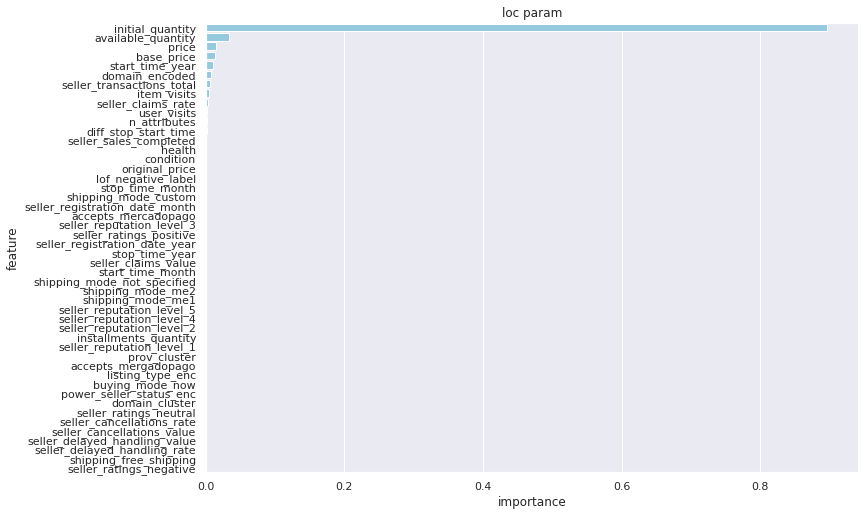

In [35]:
colist = df.columns.tolist()
colist.remove('sold_quantity')
df_loc = (pd.DataFrame({'feature':colist, 
                       'importance':feature_importance_loc})
          .sort_values('importance',ascending=False))

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x='importance',y='feature',data=df_loc, color="skyblue").set_title('loc param')



### Vemos que considera muy pocas, y de entre ellas, por lejos initial quantity sobresale primera, luego en mucho menor medida le sigue available quantity. Puede parecer una obviedad, pero tiene sentido que dichos datos sean buenos predictores, ya que aunque correlacionadas positivamente entre si(como hemos visto en EDA), dan un marco claro y directo en que la posible cantidad vendida varie. 

### Procedamos al CV

In [48]:
ngboost_metrics = pd.DataFrame()
ngboost_results_stored = {}


kf = KFold(n_splits=8)

for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(i)
    X_train_cv, X_val = X_train[train_index], X_train[test_index]
    y_train_cv, y_val = y_train[train_index], y_train[test_index]

    ngboost_results_stored[i] = {} 

    ngb = NGBRegressor(Dist=Poisson).fit(X_train_cv, y_train_cv)
    y_pred_ngb_cv = ngb.predict(X_val)

    
    ngboost_results_stored[i]['y_test'] = [y_val]
    ngboost_results_stored[i]['y_pred'] = [y_pred_ngb_cv]
    for metric in metrics:
        ngboost_metrics.loc[i, metric] = metrics[metric](y_val, y_pred_ngb_cv)


0
[iter 0] loss=80.8630 val_loss=0.0000 scale=0.0312 norm=0.0460
[iter 100] loss=49.2134 val_loss=0.0000 scale=1.0000 norm=0.9928
[iter 200] loss=27.2921 val_loss=0.0000 scale=2.0000 norm=1.6077
[iter 300] loss=22.4033 val_loss=0.0000 scale=1.0000 norm=0.7079
[iter 400] loss=20.8620 val_loss=0.0000 scale=2.0000 norm=1.4088
1
[iter 0] loss=77.3800 val_loss=0.0000 scale=0.0312 norm=0.0457
[iter 100] loss=45.2510 val_loss=0.0000 scale=0.2500 norm=0.2433
[iter 200] loss=24.8632 val_loss=0.0000 scale=2.0000 norm=1.5784
[iter 300] loss=21.0777 val_loss=0.0000 scale=2.0000 norm=1.4054
[iter 400] loss=19.6233 val_loss=0.0000 scale=1.0000 norm=0.7033
2
[iter 0] loss=76.6015 val_loss=0.0000 scale=0.0625 norm=0.0915
[iter 100] loss=47.8561 val_loss=0.0000 scale=1.0000 norm=1.0032
[iter 200] loss=26.2290 val_loss=0.0000 scale=1.0000 norm=0.8068
[iter 300] loss=21.1872 val_loss=0.0000 scale=2.0000 norm=1.4204
[iter 400] loss=19.8199 val_loss=0.0000 scale=1.0000 norm=0.7024
3
[iter 0] loss=80.9640 v

### Test Held Out

### Regresion GLM Poisson

In [66]:


y_pred_ho = po_results_trun.predict(X_test_rl)


for metric in metrics:
    print(f"{metric} in Poisson Regression Test {metrics[metric](y_test_rl, y_pred_ho)}")

mse in Poisson Regression Test 36158.57379291759
r2 in Poisson Regression Test 0.040934715432105695


### NGBoost

In [65]:

ngb = NGBRegressor(Dist=Poisson).fit(X_train, y_train)
y_pred_ngb_test = ngb.predict(X_test)


for metric in metrics:
    print(f"{metric} in NGBoost Test {metrics[metric](y_test, y_pred_ngb_test)}")

[iter 0] loss=79.2402 val_loss=0.0000 scale=0.0312 norm=0.0458
[iter 100] loss=48.0928 val_loss=0.0000 scale=0.2500 norm=0.2472
[iter 200] loss=26.6599 val_loss=0.0000 scale=2.0000 norm=1.6002
[iter 300] loss=21.9900 val_loss=0.0000 scale=1.0000 norm=0.7068
[iter 400] loss=20.6025 val_loss=0.0000 scale=1.0000 norm=0.7009
mse in NGBoost Test 26452.45770383828
r2 in NGBoost Test 0.29837846977744953


## Evaluación y Conclusión

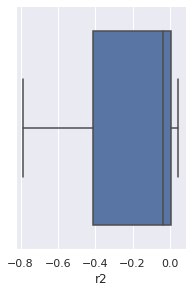

In [59]:
g = sns.catplot(x="r2",
                data=sm_metrics, kind="box",
                height=4, aspect=.7)

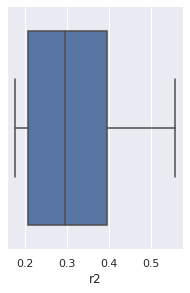

In [60]:
g = sns.catplot(x="r2",
                data=ngboost_metrics, kind="box",
                height=4, aspect=.7)

### Terminado el entrenamiento, vemos que los modelos ambos han performado mal en terminos de error sobre lo predicho. Las métricas no arrojan buenos resultados, aunque mejor el ensamble de árboles: mirando la metrica r2, donde 1 es la mejor performance, el mejor, no pasa del 0,2. 
### Los gráficos de caja muestran ademas gran variabilidad en los resultados, dando cuenta dela intestabilidad de los mismos.
### Quedan muchas cosas por hacer fuera del alcance de este trabajo:
* Un mas profundo feature engineering en base a procesamiento de imágenes de los productos y vendedor, con redes profundas, para tener un feature según un clasificador
* Un procesamiento del lenguage expresado en las preguntas y descripción del producto, para poder extraer los conceptos y la red de los mismos.
* Un ranking de ciudades segun si conexion con los hubs. 
* Una optimización de los parametros del NGBoost, posiblemente con optimización bayesiana o algoritmo genetico
* Entrenar una red profunda regresora, como un último modelo en direccion a lo no-lineal, siguiendo el camino que comenzamos